# 2. Fundamental matrix $F$

Fundamental matrix는 epipolar geometry의 대수적인 표현입니다.

그림 9.1에서 한 view에서의 점 x가 다른 view에서의 epipolar line l’로 사영됨을 보였습니다.

Fundamental matrix $F$는 $x'^\intercal F x=0$을 만족합니다. 이것으로 알 수 있는 것은 $Fx$가 어떤 선이라는 것인데, 위에서 봤다시피 epipolar line $l'$가 됩니다. 따라서 fundamental matrix는 한 view에서의 점 x를 다른 view의 epipolar line $l'$로 변환하는 matrix라고도 볼 수 있습니다.

![epipolar_line.png](./figures/epipolar_line.png)

위와 같이 Epipolar line을 그리기 위해서는 Fundamental matrix를 알고 있어야 합니다. Fundamental Matrix를 구하는 방법은 이후 Chapter 11에서 다루고 있으니 여기서는 Fundamental matrix를 알고 있다는 가정하에 코드를 작성하였습니다.

이번 코드에서는 8 point 알고리즘을 이용해서 Fundamental matrix를 구하는 방법을 알아봅니다. stereo matching pair인 이미지 한 쌍에서 일치하는 특징을 찾아 점을 찍어주고 각 이미지들에서 점이 8개 선정되었으면 알고리즘에 따라 계산합니다.

Fundamental Matrix Estimation
Load saved point coordinates for each image
[+] Compute Fundamental Matrix...
F
 [[-3.75611048e-05 -1.65786090e-03  2.95862698e-01]
 [ 1.58254584e-03 -5.57802694e-05 -6.50657428e-01]
 [-2.61503172e-01  6.44067147e-01 -7.68018150e-02]]
F_
 [[-3.62394276e-05 -1.65732390e-03  2.95862701e-01]
 [ 1.58314642e-03 -5.55362523e-05 -6.50657427e-01]
 [-2.61503169e-01  6.44067148e-01 -7.68018149e-02]]
[++] Compute Fundamental Matrix... Done
[+] Normalize points...
[++] Normalize points... Done
[+] Normalize points...
[++] Normalize points... Done
[+] Compute Fundamental Matrix...
F
 [[-6.63491539e-03 -3.05322175e-01  2.23507677e-01]
 [ 2.90673544e-01 -1.01243516e-02 -5.92923132e-01]
 [-2.18224797e-01  6.10741314e-01 -4.45866503e-04]]
F_
 [[-2.62941788e-03 -3.03907544e-01  2.25461224e-01]
 [ 2.92200391e-01 -9.58511153e-03 -5.92178464e-01]
 [-2.16210029e-01  6.11452874e-01  5.36769228e-04]]
[++] Compute Fundamental Matrix... Done
Fundamental Matrix Calculated
F(8-points

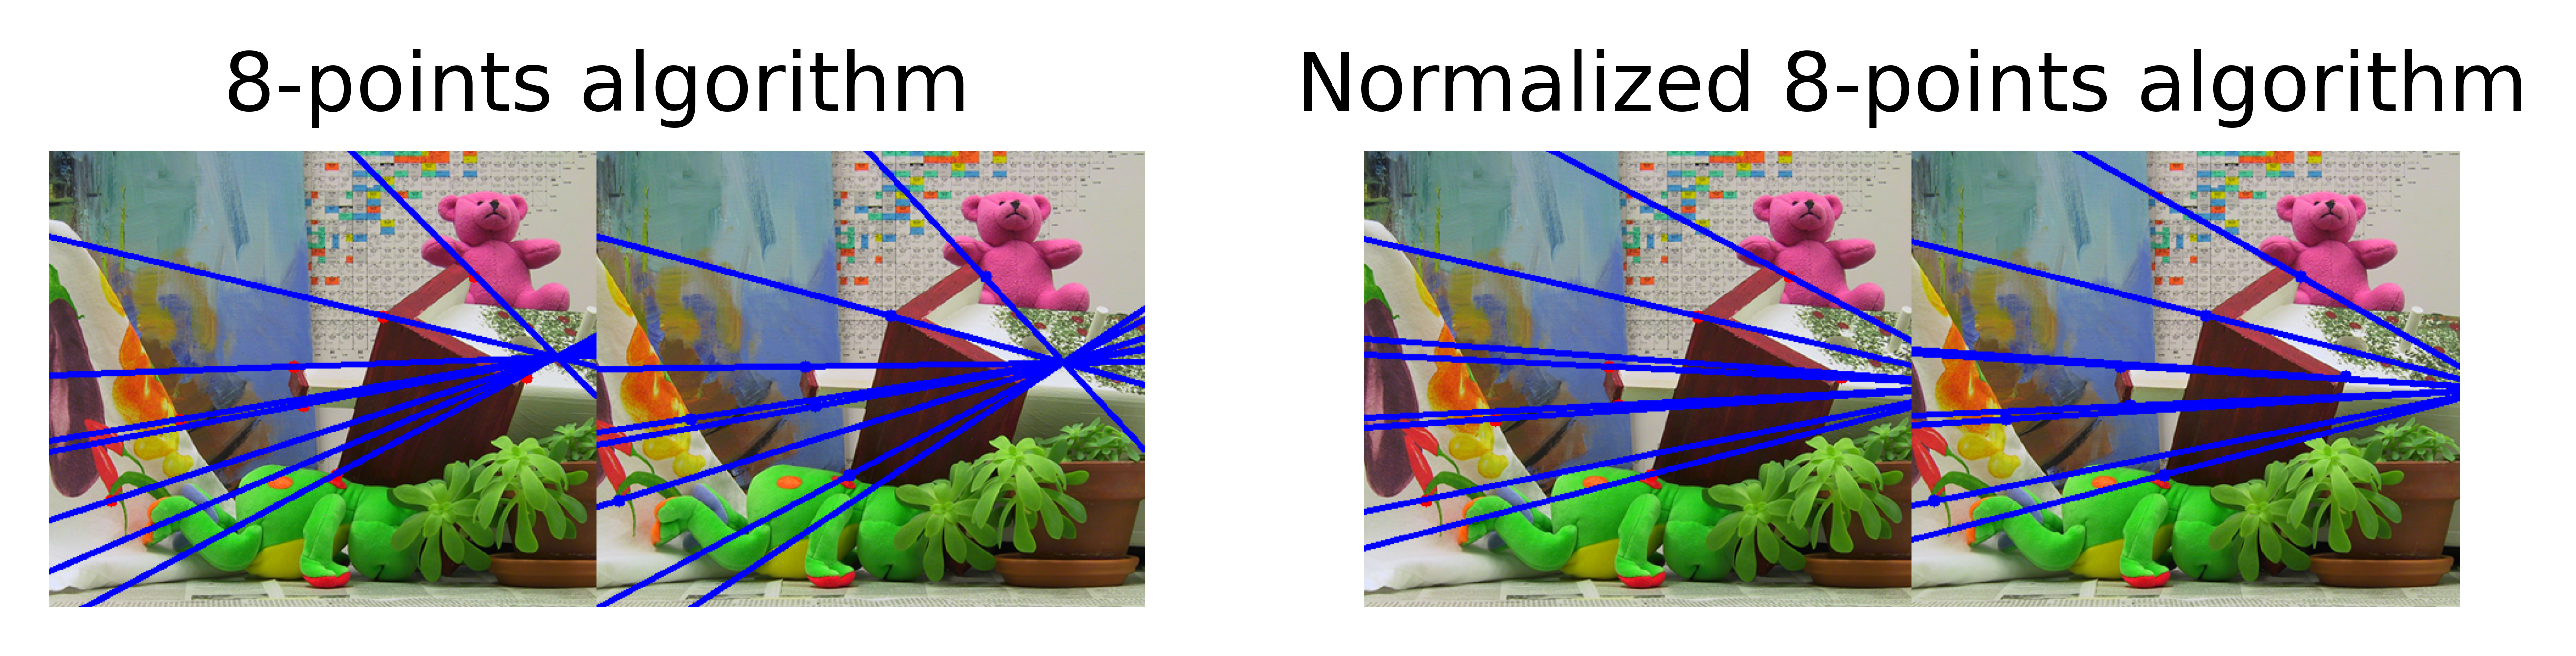

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

point_color = (0, 0, 255)
img_show = None
points = []

def normalise2dpts(pts_: np.ndarray):
    print('[+] Normalize points...')

    # scale to 1
    pts = pts_.copy().astype(np.float32)
    pts = pts / pts[:, 2][:, np.newaxis]
    pts[:, 2] = 1.0

    # calculate dist & scale
    c = np.mean(pts[:2], axis=0)  # Centroid of finite points
    pts_temp = pts.copy()
    pts_temp[:, 0] -= c[0]
    pts_temp[:, 1] -= c[1]
    dist = np.sqrt(pts_temp[:, 0] ** 2 + pts_temp[:, 1] ** 2)
    meandist = np.mean(dist)

    scale = np.sqrt(2) / meandist

    # normalization matrix
    T = np.array([
        [scale, 0.0, -scale * c[0]],
        [0.0, scale, -scale * c[1]],
        [0.0, 0.0, 1.0]
    ])

    pts = (T @ pts.T).T
    print('[++] Normalize points... Done')
    return pts, T

def compute_F(x1, x2):
    # TODO: complete the function
    print('[+] Compute Fundamental Matrix...')
    N = len(x1)

    A = np.zeros((N,9), dtype=np.float64)
    for i in range(N):
        x1_, y1_, _ = x1[i]
        x2_, y2_, _ = x2[i]

        A[i] =       [x2_*x1_, x2_*y1_, x2_, y2_*x1_, y2_*y1_, y2_, x1_, y1_, 1]


    # SVD for F
    U, s, Vh = np.linalg.svd(A)
    p = Vh[np.argmin(s)]
    F = p.reshape(3, 3)

    # Enforce rank 2
    U, s, Vh = np.linalg.svd(F)
    print('F\n', F)
    F = U @ np.diag([s[0], s[1], 0]) @ Vh
    print('F_\n', F)

    print('[++] Compute Fundamental Matrix... Done')
    return F

def draw_homogeneous_line(img_, lt: np.ndarray, color=(255, 0, 0), line_width=5):
    img = img_.copy()
    _, W, _ = img.shape

    a, b, c = lt.reshape(-1)

    x = np.array([0, W])
    y = -(x * a + c) / b

    y = y.astype(np.int32)
    x = x.astype(np.int32)

    img = cv2.line(img, (x[0], y[0]), (x[1], y[1]), color, line_width)
    return img

def draw_points(image1, img1_points, image2, img2_points):
    global img_show
    
    for img1_point, img2_point in zip(img1_points, img2_points):
        cv2.circle(image1, (img1_point[0], img1_point[1]), 5, (0,0,255), -1)
        cv2.circle(image2, (img2_point[0], img2_point[1]), 5, (255,0,0), -1)

    img_show = np.concatenate((image1, image2), axis=1)

    return img_show

def calculate_distance_line2point(lt: np.ndarray, point_):
    # d = (ax+by+c)/sqrt(a^2+b^2)
    a, b, c = lt.reshape(-1)
    point = point_ / point_[2]  # [x, y, 1]
    x, y, _ = point
    d = np.abs(a * x + b * y + c) / np.sqrt(a ** 2 + b ** 2)
    return d


def main():
    print('Fundamental Matrix Estimation')

    global img_show, points, point_color
    
    img_root = './figures/9.2_example/'
    image1 = cv2.imread(os.path.join(img_root, 'im2.png'))
    image2 = cv2.imread(os.path.join(img_root,'im6.png'))

    img_ratio = 1.0
    if img_ratio != 1.0:
        image1 = cv2.resize(image1, dsize=(0, 0), fx=img_ratio, fy=img_ratio)
        image2 = cv2.resize(image2, dsize=(0, 0), fx=img_ratio, fy=img_ratio)

    H, W, C = image1.shape

    print('Load saved point coordinates for each image')
    img1_points = np.load('image1.npy')
    img2_points = np.load('image2.npy')
    img_show = draw_points(image1, img1_points.astype(np.int32), image2, img2_points.astype(np.int32))

    # 8-point algorithm
    F = compute_F(img1_points, img2_points)

    # Normalized 8-point algorithm
    img1_points_n, T1 = normalise2dpts(img1_points)
    img2_points_n, T2 = normalise2dpts(img2_points)
    F_norm = T2.T @ compute_F(img1_points_n, img2_points_n) @ T1

    print('Fundamental Matrix Calculated')
    print('F(8-points):', F)
    print('F(normalized 8-points):', F_norm)

    print('x\' * F * x:\n', img2_points @ F * img1_points)
    print('x\' * F_norm * x:\n', img2_points @ F_norm * img1_points)

    error_xl = np.array([calculate_distance_line2point(lt_, p_)
                         for lt_, p_ in zip((F @ img1_points.T).T, img2_points)])
    error_xl_n = np.array([calculate_distance_line2point(lt_, p_)
                           for lt_, p_ in zip((F_norm @ img1_points.T).T, img2_points)])

    print('F - Error:', np.mean(error_xl))
    print('F_norm - error:', np.mean(error_xl_n))

    # Show epipolar lines
    # 1) 8-points algorithm
    img1_with_l = img_show[:, :W].copy()
    img2_with_l = img_show[:, W:].copy()
    for line in (F.T @ img2_points.T).T:
        img1_with_l = draw_homogeneous_line(img1_with_l, line, line_width=3)
    for line in (F @ img1_points.T).T:
        img2_with_l = draw_homogeneous_line(img2_with_l, line, line_width=3)

    # 2) Normalized 8-points algorithm
    img1_with_l_norm = img_show[:, :W].copy()
    img2_with_l_norm = img_show[:, W:].copy()
    for line in (F_norm.T @ img2_points.T).T:
        img1_with_l_norm = draw_homogeneous_line(
            img1_with_l_norm, line, line_width=3)
    for line in (F_norm @ img1_points.T).T:
        img2_with_l_norm = draw_homogeneous_line(
            img2_with_l_norm, line, line_width=3)

    fig = plt.figure(dpi=1000)

    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(cv2.cvtColor(np.concatenate((img1_with_l, img2_with_l), axis=1), cv2.COLOR_BGR2RGB))
    ax1.set_title('8-points algorithm')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(cv2.cvtColor(np.concatenate((img1_with_l_norm, img2_with_l_norm), axis=1), cv2.COLOR_BGR2RGB))
    ax2.set_title('Normalized 8-points algorithm')
    ax2.axis('off')

    plt.show()


if __name__ == '__main__':
    main()

## 2.1 기하학적 유도
![geometric_derivation](./figures/geometric_derivation.png)

그림 9.5는 기하학적인 방법을 통해 F를 유도하는 것에 대해 설명합니다. 이 유도 과정은 크게 2가지 단계로 나뉘며, 두 이미지 점 x, x’와 camera center C, C’가 주어졌을 경우를 가정합니다.

1. 2차원 평면끼리의 homography $H_\pi$ 결정
2. epipolar line 결정
    1. 두 시점의 camera center가 주어졌으니, baseline을 계산할 수 있습니다. 또한, 이 계산된 baseline을 이용해 epipole의 위치를 알 수 있습니다. 이 epipole을 각 이미지에서 e, e’이라 하겠습니다.
    2. 여기서 구한 epipole을 통해 $l'=e' \times x'$와 같은 수식으로 epipolar line l과 l’을 구할 수 있습니다.
    3. 이 때, $x'=H_\pi x$라 하면, $l' = [e']_\times H_\pi x = Fx$를 얻을 수 있습니다.
        
        이 때,  $[e]_\times = 
        \begin{bmatrix}
        0 & -e_3 & e_2 \\
        e_3 & 0 & -e_1 \\
        -e_2 & e_1 & 0
        \end{bmatrix}$입니다.
        


## 2.2 대수적 유도

projection matrix P, P’를 이용한 fundamental matrix는 대수적으로 유도할 수 있습니다.

P와 P’에 의해 계산되는 fundamental matrix는 아래의 수식을 만족합니다.

$$
F=[e']_\times P'P^+
$$

여기서 $P^+= P^\intercal(PP^\intercal)^{-1}$이며, $PP^+=0$을 만족합니다.

이전에 camera model 파트에서 학습하기를, 점을 ray로 역사영할 때 이 해의 집합은 $X(\lambda)=P^+x+\lambda C$ 입니다. 여기서 $C$는 camera center이며, $PC=0$을 만족하는 $P$의 영벡터입니다. 이 ray를 정의할 수 있는 두 점은 $\lambda$가 0일 때와 $\infin$일 때 2가지로, 위 수식에서 $P^+x$와 $C$ 입니다. 이것을 두 번째 이미지에 사영하는 것이니, 각각 $P'$를 곱해 $P'P^+x,\ P'C$가 됩니다. 따라서 이 둘을 연결하는 선이 $l'$가 되는데, $l' = P'C \times P'P^+x$가 됩니다. 결국 $P'C = e'$라고 볼 수 있고, 정리하면 $[e']_\times P'P^+x = Fx$가 됩니다. 따라서 위 수식을 만족하게 됩니다.

이전에 본 수식과 동일한 형태로 변형되었는데, 이는 결국 $P'P^+=H_\pi$ 임을 의미합니다.

## 2.3 대응 조건

Fundamental matrix는 두 이미지의 대응점 $x, x'$의 모든 쌍에 대해 $x'^\intercal F x=0$을 만족합니다.

이 조건이 중요한 이유는 굳이 카메라 행렬을 필요로 않고 대응점만으로 계산할 수 있기 때문입니다. 해당 알고리즘은 이후 11장에서 다룹니다.

## 2.4 Fundamental matrix의성질

- $F$의 dof는 7이며, rank가 2인 homogeneous matrix
- $x, x'$가 대응하는 이미지 점이면, $x'^\intercal F x=0$를 만족
- epipolar line $l'=Fx,$ $l=Fx'$. 즉, 각각 $x, x'$에 대응되는 선
- $Fe=0,\ F^\intercal e'=0$
    - $l=Fx$은 epipole $e$를 포함합니다. 따라서 $e^\intercal Fx=0$이고, $e'$는 $F$의 left null vector가 되며 $e$와 $F$의 경우도 비슷합니다.
- 전치 성질을 가집니다. 여기서 전치 성질이라 함은, $(P,P')$의 fundamental matrix $F$ 가 있다고 할 때, $(P',P)$ 의 fundamental matrix는 $F^\intercal$ 이 된다는 것입니다.

## 2.5. Essential matrix

사실상 Essential matrix는 fundamental matrix에서 카메라가 calibration 되었을 경우로, fundamental matrix는 essential matrix의 일반형이라고 볼 수 있습니다. 따라서 Essential matrix는 기본 행렬에 비해 적은 dof를 가지며 추가적인 성질을 지닙니다. Essential matrix $E$를 $F$에 대한 수식으로 나타내면 $E=K'^\intercal F K$ 와 같습니다.

### 2.5.1 Essential matrix의 속성

1. Essential matrix $E=[t]_\times R$의 dof는 5 입니다. R과 t가 각각 3 dof를 가지나 scale을 제외해 5가 됩니다.
2. $E$는 SVD를 통해 분해했을 때 D의 첫 번째, 두 번째 특이값이 같고, 세 번째 특이값은 0입니다.

### **Reference**
1. Multiple view geometry in computer vision chapter 9.2 and 9.6